Lab 01: Introduction to Deep Learning Models, and their Training, Fine-Tuning, and Evaluation

- basic functionality of PyTorch, focusing on key operations such as data loading, data transformations, and using GPUs for acceleration

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

ModuleNotFoundError: No module named 'torchvision'

Tensors
- Tensors in PyTorch Tensors are the primary data structure in PyTorch. They are similar to NumPy arrays but have added functionality that supports GPU acceleration and automatic differentiation (autograd)

Automatic differentiation in PyTorch is a key feature for calculating gradients automatically in tensors

In [2]:
torch.cuda.is_available()

True

In [5]:
a = torch.tensor([ 1.0 , 2.0 , 3.0 ])
b = torch.tensor([ 4.0 , 5.0 , 6.0 ])

c = a + b     ### addition element-wise
print(c) 

print(f"the tensor shape is {c.shape}")
print(f"the tensor type is {c.dtype}")

tensor([5., 7., 9.])
the tensor shape is torch.Size([3])
the tensor type is torch.float32


float32 (single precision) data type. NumPy, instead, defaults to float64 (double precision)

In [6]:
from timeit import timeit

mat_size = 1000

M1_64 = torch.randn(mat_size, mat_size, dtype=torch.float64)   ### here we have a tensor of double precision float64
M2_64 = torch.randn(mat_size, mat_size, dtype=torch.float64)

M1_32 = torch.randn(mat_size, mat_size)                        ### here we have a tensor of single precision float32
M2_32 = torch.randn(mat_size, mat_size)

t64 = timeit(lambda: M1_64 @ M2_64, number=100)                # we use the lambda function tu compute 100 times matrices product      
t32 = timeit(lambda: M1_32 @ M2_32, number=100)

print(f"Time for matrix multiplication (float64): {t64:.4f}s")
print(f"Time for matrix multiplication (float32): {t32:.4f}s")

Time for matrix multiplication (float64): 1.7044s
Time for matrix multiplication (float32): 0.7965s


if is strictly needed you can change the type of array 

In [6]:
c = c.to(torch.float64) # or,
print(type(c)) 
c = c.double()

<class 'torch.Tensor'>


Exercise 1: A simple neural network

-univariate linear model is one of the most basic forms of machine learning models and is defined by the equation y = wx + b

Model Definition: SimpleLinearModel
The SimpleLinearModel class is a subclass of nn.Module, which is the base class for all neural network modules in PyTorch

The SimpleLinearModel class is structured as follows:

__init__(self, input_size, output_size):

This is the constructor method where the linear layer is defined. The input_size and output_size parameters specify the dimensions of the input and output features, respectively. In this exercise, both the input and output sizes are set to 1, indicating a single feature input and a single prediction output.
forward(self, x):

This method defines the forward pass of the model, where the input x is passed through the linear layer. The forward pass computes the output by applying the linear transformation described above

In [7]:
# Define a simple linear model
class SimpleLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

In [12]:
# Initialize the model, loss function, and optimizer
model = SimpleLinearModel(1, 1)
print(model)

SimpleLinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


Using torch.device for GPU Acceleration

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"The device is set to: {device}")

The device is set to: cpu


Finally, note that these tensors have the requires_grad attribute set to True. This attribute is used by PyTorch to determine which tensors should have their gradients computed during the backward pass (i.e., which tensors are learnable parameters). This is used by PyTorch to keep track of the computational graph.

In [14]:
print("Weight", model.linear.weight)
print("Bias", model.linear.bias)

Weight Parameter containing:
tensor([[0.6712]], requires_grad=True)
Bias Parameter containing:
tensor([-0.4391], requires_grad=True)


Criterion and Optimizer

-The criterion, also known as the loss function, is a measure of how well the model's predictions match the actual target values. During training, the loss function evaluates the difference between the predicted outputs and the true labels, quantifying the error of the model. The goal of training is to minimize this error, thereby improving the model's accuracy.

-Cross Entropy: Used for multi-class classification problems, like our CIFAR-10 and CIFAR-100 tasks. We typically use PyTorch's CrossEntropyLoss, which takes as input the predicted logits (not the probabilities, so unnormalized probabilities that have not been passed through a softmax) is applied) and the ground truths. Alternatively, we could combine LogSoftmax and NLLLoss (Negative Log Likelihood Loss) together, or applying the softmax ourselves and then using a Negative Log Likelihood function. However, for numerical reasons, we generally prefer using the CrossEntropyLoss class directly.

-Mean Squared Error (MSE): Typically used for regression tasks, where the model predicts continuous values.

Optimizer
The optimizer is an algorithm or method used to adjust the model's weights to minimize the loss function. It updates the model parameters (weights and biases) based on the gradients computed during backpropagation. The optimizer aims to find the optimal set of parameters that reduce the loss, improving the model’s performance on the training data.

Some common optimizers include:

-Stochastic Gradient Descent (SGD): A basic optimizer that updates the model parameters using a small, randomly selected subset of data (mini-batch) instead of the entire dataset. It’s useful for handling large datasets and reducing computational cost.

-Adam: A more advanced optimizer that combines the benefits of two other extensions of SGD, Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). It adjusts the learning rate for each parameter dynamically, making it well-suited for complex tasks with sparse gradients.

In [15]:
# Create a dataset (for simplicity, we use a small synthetic dataset)
# X is the input features, y is the target labels

n_pts = 2048
# TODO: Generate a random dataset containing n_pts samples
# Notes:
# - The input features X should be a tensor of shape (n_pts, 1)
# - you can generate the X's randomly (e.g. using torch.rand to sample uniformly from [0,1], or torch.randn to sample from a normal distribution)
# - The target labels y should be a linear function of X with some noise added, y = w*x + b + gaussian noise

# In this solution we are using normally distributed inputs. It is 
# well-known that 0-centered inputs help speed up the learning process.
# You can try using uniformly distributed inputs, or adding an offset to
# all points and see the difference in learning speed (weight/bias
# plots shown afterwards)
X = torch.randn(n_pts, 1)      ### shape is [ 2048 , 1 ]
y = 5 * X + 3 + 0.1 * torch.randn(n_pts, 1) # adding gaussian noise  ### shape is [ 2048 , 1 ]

# Create DataLoader
dataset = TensorDataset(X, y)
trainloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [17]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Training Loop 


In [18]:
# Training loop
num_epochs = 50

# TODO: keep track of the loss computed at each step, 
# the current value for the weight of the linear layer,
# and the current bias value for the linear layer.
# Note: store the values in the lists losses, weights, biases
losses = []
weights = []
biases = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Save the loss, weight, and bias
        losses.append(loss.item())
        weights.append(model.linear.weight.item())
        biases.append(model.linear.bias.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

Epoch [1/50], Loss: 26.0355
Epoch [2/50], Loss: 19.0162
Epoch [3/50], Loss: 13.8880
Epoch [4/50], Loss: 10.1432
Epoch [5/50], Loss: 7.4104
Epoch [6/50], Loss: 5.4142
Epoch [7/50], Loss: 3.9559
Epoch [8/50], Loss: 2.8913
Epoch [9/50], Loss: 2.1141
Epoch [10/50], Loss: 1.5463
Epoch [11/50], Loss: 1.1320
Epoch [12/50], Loss: 0.8294
Epoch [13/50], Loss: 0.6085
Epoch [14/50], Loss: 0.4471
Epoch [15/50], Loss: 0.3293
Epoch [16/50], Loss: 0.2432
Epoch [17/50], Loss: 0.1804
Epoch [18/50], Loss: 0.1345
Epoch [19/50], Loss: 0.1010
Epoch [20/50], Loss: 0.0765
Epoch [21/50], Loss: 0.0587
Epoch [22/50], Loss: 0.0456
Epoch [23/50], Loss: 0.0361
Epoch [24/50], Loss: 0.0291
Epoch [25/50], Loss: 0.0241
Epoch [26/50], Loss: 0.0203
Epoch [27/50], Loss: 0.0176
Epoch [28/50], Loss: 0.0157
Epoch [29/50], Loss: 0.0142
Epoch [30/50], Loss: 0.0132
Epoch [31/50], Loss: 0.0124
Epoch [32/50], Loss: 0.0118
Epoch [33/50], Loss: 0.0114
Epoch [34/50], Loss: 0.0111
Epoch [35/50], Loss: 0.0109
Epoch [36/50], Loss: 0.01

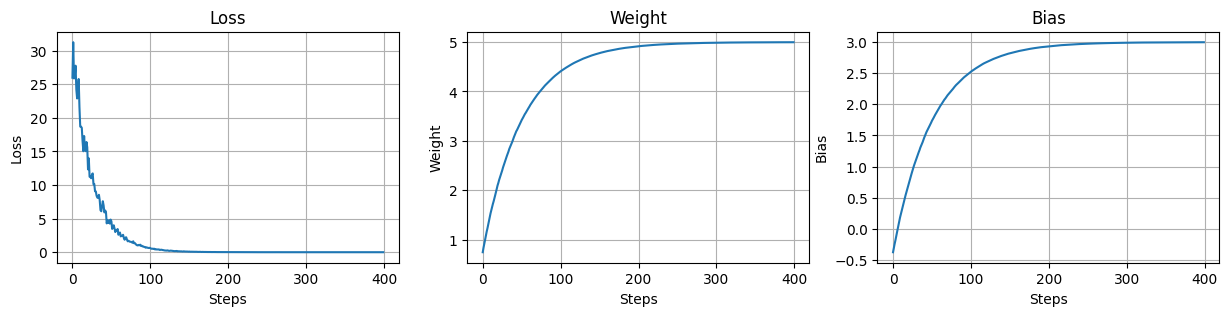

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].plot(losses)
ax[0].set_title("Loss")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(weights)
ax[1].set_title("Weight")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Weight")
ax[1].grid()

ax[2].plot(biases)
ax[2].set_title("Bias")
ax[2].set_xlabel("Steps")
ax[2].set_ylabel("Bias")
ax[2].grid()

In [20]:
# Inspecting the learned weights and biases
weights = model.linear.weight.data
biases = model.linear.bias.data

print(f'Learned weights: {weights}')
print(f'Learned biases: {biases}')

Learned weights: tensor([[4.9978]])
Learned biases: tensor([2.9996])


Exercise 2: First Model Training

you will explore the concept of transfer learning by training a model on the CIFAR-10 dataset and then adapting it to a different dataset, CIFAR-100

This approach is especially useful in fields like Natural Language Processing (NLP), where training a model from scratch requires immense computational resources and vast amounts of data. Instead, pre-trained models are often used as backbones, and only the final classification head is fine-tuned for specific tasks.

The CIFAR-10 and CIFAR-100 datasets are both standard datasets in computer vision. They contain 32x32 color images, but while CIFAR-10 has 10 classes, CIFAR-100 has 100 classes, making it a more challenging task.

In this exercise, you will:

Train a model from scratch on CIFAR-10 and evaluate its performance.

Compare the performance on CIFAR-10 of two models:

-The model trained from scratch from point 1.

-A model pre-trained on ImageNet (another dataset of images) and then fine-tuned on CIFAR-10.

-Modify the classification head to adapt the model for CIFAR-100.

Loading the CIFAR-10 Dataset and Creating a DataLoader

We apply a simple transformation to the images, which start out as PIL images (PIL is a famous Python libraries that handles images), 
to convert them into PyTorch tensors. We do this using the transforms.ToTensor() transformation.

In [ ]:
dataset_dir = "~/data" # Change this to the directory where you want to download the dataset
# Download CIFAR-10 dataset and apply the transformations
trainset = torchvision.datasets.CIFAR10(
    root=dataset_dir, train=True, download=True, transform=transforms.ToTensor()
)

# Create a DataLoader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)

# Get a batch of data to verify that everything is working
# dataiter = iter(trainloader)
images, labels = next(iter(trainloader)) #dataiter.next()

print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels shape: {labels.shape}")
print(f"Possible classes: {', '.join(trainset.classes)}")

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(8,8, figsize=(8,8))
plt.rcParams.update({'axes.titlesize': 'small'})
plt.tight_layout()
# remove vertical space
plt.subplots_adjust(hspace=0.25, wspace=0.1)

for i in range(8):
    for j in range(8):
        # note that we need to change the order of the dimensions.
        # Torch prepare the images to be (C, H, W),
        # But matplotlib expects (H, W, C)
        # (H = height of the image, W = width of the image, C = number of color channels)
        ax[i,j].imshow(images[i*8 + j].permute(1,2,0))
        ax[i,j].set_title(trainset.classes[labels[i*8 + j]])
        ax[i,j].axis('off')

Data Transformations

Transformations involve modifying the inputs (e.g., images) in the dataset to make the model more robust to variations in input data and prevent overfitting

It's important to note that the transformations applied to the training data differ from those applied to the validation data

Training Transformations

Training transformations are designed to augment the dataset, effectively increasing the diversity of the input images seen by the model during training. This helps improve the model's ability to generalize to unseen data. Common training transformations include:

Random Crop: Randomly crops a given portion of an image. This helps the model become invariant to the position of objects within the image.

Random Horizontal Flip: Randomly flips an image horizontally. This technique ensures that the model learns features regardless of the orientation of objects.

Normalization: Adjusts the pixel values to have a mean of 0 and a standard deviation of 1. Normalization helps speed up training and can lead to better model performance.




Validation Transformations
Validation transformations, on the other hand, are intended to provide a consistent evaluation of model performance by ensuring the input data is in a standardized format. Typically, validation transformations include:

Normalization: Similar to training, normalization is applied to adjust the pixel values to have a mean of 0 and a standard deviation of 1. This ensures that the distribution of values in the validation samples is the same one used in the training samples (since the model already learned to expect that distribution of values).

So, the key difference is that training transformations often include random augmentations (such as cropping and flipping) to introduce variability, whereas validation transformations are more standardized and deterministic to provide a stable basis for evaluating the model's performance

In [26]:
# TODO: find the mean value and the standard deviation of the images in the dataset
# Note:
# - The images are available in trainset.data
# - Scale the images to the [0,1] range before proceeding
# - Compute a different mean and standard deviation for each color channel
images_mean = trainset.data.mean(axis=(0,1,2)) / 255
images_std = trainset.data.std(axis=(0,1,2)) / 255

images_mean, images_std

NameError: name 'trainset' is not defined

To apply the transformations, we can pass the transformation objects to the transform argument of the CIFAR10 class. This way, the transformations are automatically applied when loading the data using the DataLoader.

Let's see what the same image looks like after applying these transformations.

Note that we are creating a different transformation, without the normalization step (& conversion to tensor), for the visualization. This occurs because the normalization step would make the image look strange, as it would change the pixel values to have a mean of 0 and a standard deviation of 1.

In [ ]:
viz_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # note the padding_mode policy: this implies that the "missing" pixels
    # will be reflected from the border pixels
    # (more info in the documentation => https://pytorch.org/vision/main/generated/torchvision.transforms.RandomCrop.html)
    transforms.RandomCrop(32, padding_mode='reflect', padding=5)
])

im = transforms.ToPILImage()(images[10])
n_transforms = 9

fig, ax = plt.subplots(3,3, figsize=(4,4))
# TODO: Visualize the original image ,then apply different transformations to it
# Note: each time you apply the viz_transform transformation, a random transformation will be applied to the image
for i in range(n_transforms):
    if i == 0: # The first image is the original one
        ax[i//3,i%3].imshow(im)
    else: # The rest are the transformed images
        ax[i//3,i%3].imshow(viz_transform(im))
    ax[i//3,i%3].axis('off')

Extra stuff!

Other transformations are already supported in PyTorch, such as:

RandomRotation: Rotates the image by a random angle.
RandomResizedCrop: Crops the image to a random size and aspect ratio, then resizes it to the specified size.
ColorJitter: Randomly changes the brightness, contrast, saturation, and hue of an image.
RandomAffine: Applies a random affine transformation to the image.
RandomPerspective: Applies a random perspective transformation to the image.
RandomErasing: Randomly selects a rectangle region in an image and erases its pixels.
You can find out more about those transformations in the official documentation.


2.0 Building and Training a Simple Neural Network for CIFAR-10 Classification
In this exercise, we extend our exploration of machine learning models by constructing a simple neural network to classify images from the CIFAR-10 dataset using PyTorch. Unlike the linear model, which is limited to learning linear relationships between features, this neural network introduces multiple layers and non-linear activation functions, allowing it to capture more complex patterns in the data.

A neural network consists of interconnected layers of nodes, or neurons, where each layer applies a linear transformation to its input, followed by a non-linear activation. The architecture we will implement includes:

Input Layer: Accepts the flattened input image, with each pixel value as a feature.
Hidden Layers: Two fully connected layers that transform the input into higher-level features using linear transformations and ReLU activation functions.
Output Layer: A final fully connected layer that maps the transformed features to the 10 output classes of the CIFAR-10 dataset.

In [ ]:
# Define a more complex neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # TODO: Define the linear layers for the model
        # Notes:
        # - Each layer requires specifying the number of input and output features
        # - The first layer takes as input a flattened image (32x32x3) and should produce 512 features
        #   (i.e., it encodes the image into a 512-dimensional space)
        # - The second layer should produce 256 features
        # - The output layer should produce 10 features (these will be the logits)

        # number of input features: 32*32*3 (image size)
        self.fc1 = nn.Linear(32 * 32 * 3, 512)  # Input layer to first hidden layer
        self.fc2 = nn.Linear(512, 256)  # First hidden layer to second hidden layer
        self.fc3 = nn.Linear(256, 10)   # Second hidden layer to output layer


    def forward(self, x):
        # TODO: implement the forward pass
        # Notes:
        # - first step: flatten the input (preserve the batch size, flatten the rest)
        # - apply the first linear layer with ReLU activation
        # - apply the second linear layer with ReLU activation
        # - apply the output layer (no activation needed for the output layer)

        # Flatten the input
        x = x.view(-1, 32 * 32 * 3)
        # Apply layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer (no activation needed for the output layer)

        return x

Data Transformations


In [ ]:
# Define transformations for the training and test datasets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding_mode='reflect', padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Loading the CIFAR-10 Dataset

In [ ]:
# Load CIFAR-10 dataset
batch_size = 1024
trainset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root=dataset_dir, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize the model, loss function, and optimizer
model = SimpleNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def val_model(model, testloader):
    model.eval() # NOTE: required to set the model to evaluation mode (some layers may behave differently during training and evaluation)
    correct = 0
    total = 0
    with torch.no_grad(): # NOTE: we disable gradient tracking for validation, to save memory!
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy of the network on the test images: {100 * correct / total:.2f}%")

In [ ]:
val_model(model, testloader)

In [ ]:
# Training loop
num_epochs = 5

losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # TODO: let's implement the training loop for the model
        # Notes:
        # - First, zero the parameter gradients
        # - Next, get the model's predictions
        # - Compute the loss
        # - Perform backpropagation (i.e. compute all gradients)
        # - Finally, update the model's parameters

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()


        losses.append(loss.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

Extra stuff!

Now the model has a bunch more weights and biases (parameters) to learn. Unlike before, we don't know exactly what the "right" values should be. Pick a few random parameters from the various layers and keep track of how their values change over time!

(Note: make sure to extract the values from the tensors using the .item() method, as shown in the previous example, otherwise the computation graph will keep track of the values and you will run out of memory!)

Let's check the model's performance on the validation set.



In [ ]:
val_model(model, testloader)

In [ ]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

Extra stuff!

While this model performs better than random guess (~10% accuracy), it still far from perfect. Compute the confusion matrix on the validation set. Which classes does the model classify better? Which classes does it struggle with? Which classes are most often confused with each other?

Load and Train a Model on CIFAR-10

In [ ]:
# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

testset = torchvision.datasets.CIFAR10(root=dataset_dir, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

from torchvision import models

# Load a pre-trained model (ResNet18)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Training loop
num_epochs = 5

losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

In [ ]:
# Validate the model
val_model(model, testloader)

In [ ]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

Load and Train a Model on CIFAR-10

In [ ]:
# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

testset = torchvision.datasets.CIFAR10(root=dataset_dir, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

from torchvision import models

# Load a pre-trained model (ResNet18)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Training loop
num_epochs = 5

losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

In [ ]:
# Validate the model
val_model(model, testloader)

In [ ]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

 Load and Train a pre-trained Model on CIFAR-10

In [ ]:
# TODO: Load a pre-trained model (ResNet18)
# Notes:
# - To load a pre-trained model, call models.resnet18 and set the weights argument to 'DEFAULT'
# - The model has a fully connected layer at the end (called `fc`) that needs to be replaced with a new one of the appropriate size
# - To get the number of input features for the new layer, you can access the in_features attribute of the original fc layer

pretrained_model = models.resnet18(weights="DEFAULT")
pretrained_model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
pretrained_model = pretrained_model.to(device) # move the model (all layers, even new ones) to the device


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Training loop
num_epochs = 5

losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")


In [ ]:
val_model(pretrained_model, testloader)

In [ ]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

Change the Classification Head of an already trained Model on CIFAR-100

In this exercise, we will modify the classification head of a pre-trained model on CIFAR-10 to adapt it to the CIFAR-100 dataset. This process involves changing the output layer of the model to accommodate the 100 classes in CIFAR-100 instead of the 10 classes in CIFAR-10. By changing the classification head, we can repurpose the pre-trained model to perform well on a different task with minimal additional training.

We do this by employing a common technique in transfer learning, known as layer freezing, to adapt a pre-trained model to a new task with minimal training time. Layer freezing involves setting the requires_grad attribute of specific model parameters to False, effectively preventing them from being updated during the backpropagation process. By freezing all layers except for the final classification head, we retain the knowledge encoded in the pre-trained layers while allowing the model to learn task-specific features through the unfrozen layers.

In [ ]:
# Load the CIFAR-100 dataset
trainset_cifar100 = torchvision.datasets.CIFAR100(root=dataset_dir, train=True, download=True, transform=transform_train)
trainloader_cifar100 = torch.utils.data.DataLoader(trainset_cifar100, batch_size=100, shuffle=True)

testset_cifar100 = torchvision.datasets.CIFAR100(root=dataset_dir, train=False, download=True, transform=transform_test)
testloader_cifar100 = torch.utils.data.DataLoader(testset_cifar100, batch_size=100, shuffle=False)

In [ ]:
# Modify the classification head for CIFAR-100 (100 classes)

model = pretrained_model
model.fc = nn.Linear(model.fc.in_features, 100)
model = model.to(device)

In our case, we freeze all layers except for the newly modified classification head by iterating through the model's parameters and setting requires_grad = False for each. Subsequently, we explicitly enable gradient computation (requires_grad = True) for the parameters in the classification head. This approach allows us to fine-tune the output layer to classify the 100 classes in the CIFAR-100 dataset while preserving the general features learned from the CIFAR-10 dataset, ensuring that the model adapts effectively to the new task using the information already learned from the previous task.

In [ ]:
# Freeze all layers except the classification head
for param in model.parameters():
    param.requires_grad = False

# TODO: Unfreeze the classification head
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

num_epochs = 1

losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader_cifar100:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader_cifar100):.4f}")

In [ ]:
val_model(model, testloader_cifar100)

In [ ]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

PyTorch Computational Graph

In [ ]:
import torch
from torchviz import make_dot

# Define tensors with requires_grad=True to track operations
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = torch.tensor(4.0, requires_grad=True)

# Define a function involving these tensors
y = (a*b*c+c)*c + b

# Visualize the computational graph
make_dot(y, params={"a": a, "b": b, "c": c})

In [ ]:
import torch
from torchviz import make_dot

import torch

# TODO: define the tensors and compute the loss
# Define theta1, theta2, x, and y as tensors, then compute the loss
# Notes:
# - set theta1 = 2.0, theta2 = 3.0, x = 1.0, y = 3.0
# - the loss is defined as (theta1 * theta2 * x - y)^2
# - all the tensors should be specified to require gradients
theta1 = torch.tensor(2.0, requires_grad=True)
theta2 = torch.tensor(3.0, requires_grad=True)
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

loss = (theta1 * theta2 * x - y)**2

# TODO: Visualize the computational graph
make_dot(loss, params={"theta1": theta1, "theta2": theta2, "x": x, "y": y})